# Pemodelan Time Series Harga Beras Mingguan dengan LSTM

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tf.keras.utils.set_random_seed(627)

## Plotting data

In [3]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
  
  plt.figure(figsize=(10,6))

  if type(y) is tuple:
    for y_curr in y:
      plt.plot(x[start:end], y_curr[start:end], format)
  else:
    plt.plot(x[start:end], y[start:end], format)
  
  plt.xlabel(xlabel)

  plt.ylabel(ylabel)

  if legend:
    plt.legend(legend)
  
  plt.title(title)

  plt.grid(True)

  plt.show()

In [4]:
data = pd.read_csv("../data/Mingguan.csv")

In [5]:
data = data.T
data.head()

,0,1
Minggu,Beras,Beras_Medium_I
Des 2019 (V),9650,9400
Jan 2020 (I),9650,9400
Jan 2020 (II),9700,9450
Jan 2020 (III),9750,9500


In [6]:
data = data.rename(columns=data.iloc[0]).drop(data.index[0])
data.head()

,Beras,Beras_Medium_I
Des 2019 (V),9650,9400
Jan 2020 (I),9650,9400
Jan 2020 (II),9700,9450
Jan 2020 (III),9750,9500
Jan 2020 (IV),9750,9500


In [7]:
data.insert(0, 'time', range(0, len(data)))
data.head()

,time,Beras,Beras_Medium_I
Des 2019 (V),0,9650,9400
Jan 2020 (I),1,9650,9400
Jan 2020 (II),2,9700,9450
Jan 2020 (III),3,9750,9500
Jan 2020 (IV),4,9750,9500


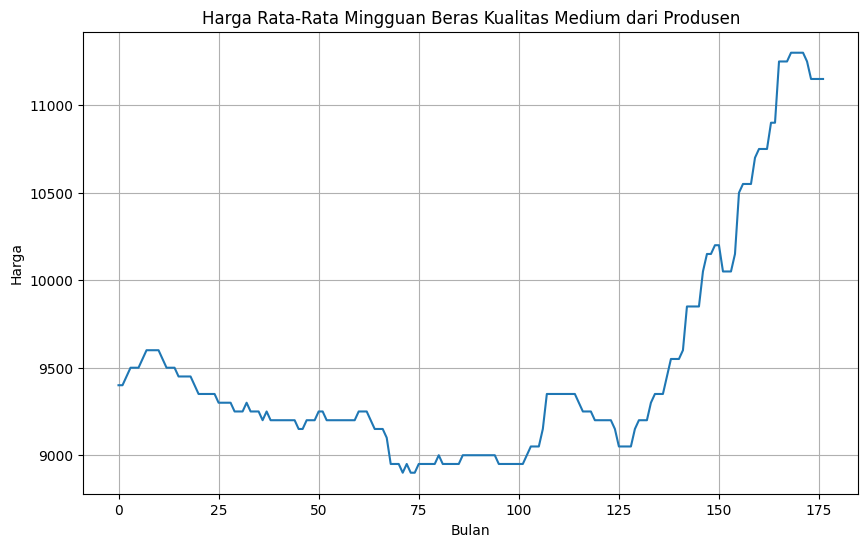

In [8]:
time_step = []
harga = []

for index, row in data.iterrows():
    time_step.append(row['time'])
    harga.append(row['Beras_Medium_I'])

time = np.array(time_step)
series = np.array(harga)

plot_series(time, series, xlabel="Bulan", ylabel="Harga", title="Harga Rata-Rata Mingguan Beras Kualitas Medium dari Produsen")

In [9]:
data.insert(0, "tanggal", pd.date_range(start="2020-01-01", periods=177, freq="W-SAT"))

In [10]:
data.head()

,tanggal,time,Beras,Beras_Medium_I
Des 2019 (V),2020-01-04,0,9650,9400
Jan 2020 (I),2020-01-11,1,9650,9400
Jan 2020 (II),2020-01-18,2,9700,9450
Jan 2020 (III),2020-01-25,3,9750,9500
Jan 2020 (IV),2020-02-01,4,9750,9500


In [11]:
beras = pd.DataFrame({'tanggal' : data['tanggal'], 'harga' : data['Beras_Medium_I']}, columns=['tanggal', 'harga'])

In [12]:
beras.set_index('tanggal', inplace=True)
beras.head()

,harga
tanggal,
2020-01-04,9400
2020-01-11,9400
2020-01-18,9450
2020-01-25,9500
2020-02-01,9500


Dilakukan juga normalisasi data dengan MinMaxScaler supaya data berada pada rentang [0,1]

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
harga_beras = scaler.fit_transform(beras)

## Set Window Size

Dalam data time series, kita dapat menggunakan runtun waktu dalam jangka tertentu untuk meramalkan data berikutnya. Hal ini disebut time window, dimana kita menggunakan n waktu sebagai window size untuk meramalkan 1 waktu setelahnya. Untuk menganalisis korelasi antara setiap runtun waktu, digunakan plot ACF.

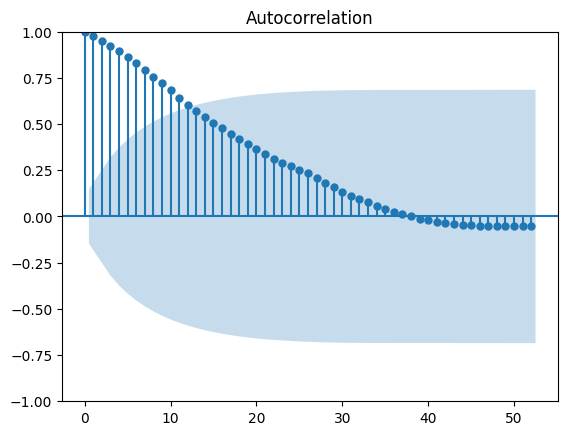

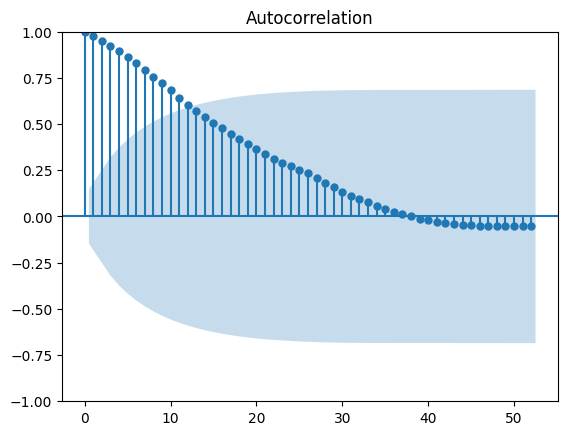

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=52)

Terlihat dari plot ACF, ACF berada di luar interval konfidensi hingga lag ke 12, artinya 12 lag pertama memiliki autokorelasi yang berbeda signifikan dengan nol.

Kita dapat mencurigai terdapat hubungan antara harga beras pada minggu ke-12 dengan 12 minggu sebelumnya. Hal ini bisa kita jadikan acuan untuk membangun window size model.

In [15]:
# Definisikan fungsi untuk membuat window size
def windowed_dataset(data, window_size):
  X = []
  y = []
  for i in range(len(data)-window_size) :
    row = [a for a in data[i:i+window_size]]
    X.append(row)
    label = data[i+5]
    y.append(label)
  return np.array(X), np.array(y).squeeze()

In [16]:
window_size = 12
X, y = windowed_dataset(harga_beras, window_size)
X.shape, y.shape

((165, 12, 1), (165,))

## Split data

Dilakukan pembagian data menjadi data train, validation, dan test

In [17]:
split_time = int(0.9*len(X))
len(X) - split_time

17

In [18]:
X_train, y_train = X[:148], y[:148]
X_val, y_val = X[148:157], y[148:157]
X_test, y_test = X[157:], y[157:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((148, 12, 1), (148,), (9, 12, 1), (9,), (8, 12, 1), (8,))

In [19]:
X_train

array([[[0.20833333],
        [0.20833333],
        [0.22916667],
        ...,
        [0.29166667],
        [0.29166667],
        [0.27083333]],

       [[0.20833333],
        [0.22916667],
        [0.25      ],
        ...,
        [0.29166667],
        [0.27083333],
        [0.25      ]],

       [[0.22916667],
        [0.25      ],
        [0.25      ],
        ...,
        [0.27083333],
        [0.25      ],
        [0.25      ]],

       ...,

       [[0.39583333],
        [0.47916667],
        [0.52083333],
        ...,
        [0.52083333],
        [0.66666667],
        [0.6875    ]],

       [[0.47916667],
        [0.52083333],
        [0.52083333],
        ...,
        [0.66666667],
        [0.6875    ],
        [0.6875    ]],

       [[0.52083333],
        [0.52083333],
        [0.54166667],
        ...,
        [0.6875    ],
        [0.6875    ],
        [0.6875    ]]])

## Modelling data

Dilakukan pemodelan dengan menggunakan layer LSTM dan dense neural network. Digunakan callback dengan checkpoint untuk menyimpan model dengan performa terbaik.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [21]:
model = Sequential()
model.add(InputLayer((12,1)))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 200,225
Trainable params: 200,225
Non-trai

In [22]:
checkpoint = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [23]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[checkpoint])

Epoch 1/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0346 - root_mean_squared_error: 0.1860

5/5 [==============================] - 8s 1s/step - loss: 0.0346 - root_mean_squared_error: 0.1860 - val_loss: 0.4207 - val_root_mean_squared_error: 0.6486
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.0318 - root_mean_squared_error: 0.1782

5/5 [==============================] - 5s 1s/step - loss: 0.0318 - root_mean_squared_error: 0.1782 - val_loss: 0.3956 - val_root_mean_squared_error: 0.6290
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.0283 - root_mean_squared_error: 0.1681

5/5 [==============================] - 5s 1s/step - loss: 0.0283 - root_mean_squared_error: 0.1681 - val_loss: 0.3702 - val_root_mean_squared_error: 0.6084
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1592

5/5 [==============================] - 4s 921ms/step - loss: 0.0254 - root_mean_squared_error: 0.1592 - val_loss: 0.3441 - val_root_mean_squared_error: 0.5866
Epoch 5/50
5/5 [==============================] - ETA: 0s - loss: 0.0226 - root_mean_squared_error: 0.1505

5/5 [==============================] - 5s 1s/step - loss: 0.0226 - root_mean_squared_error: 0.1505 - val_loss: 0.3175 - val_root_mean_squared_error: 0.5635
Epoch 6/50
5/5 [==============================] - ETA: 0s - loss: 0.0196 - root_mean_squared_error: 0.1399

5/5 [==============================] - 4s 1s/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.2903 - val_root_mean_squared_error: 0.5388
Epoch 7/50
5/5 [==============================] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.1310

5/5 [==============================] - 4s 1s/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.2607 - val_root_mean_squared_error: 0.5106
Epoch 8/50
5/5 [==============================] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1192

5/5 [==============================] - 4s 998ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.2304 - val_root_mean_squared_error: 0.4800
Epoch 9/50
5/5 [==============================] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.1075

5/5 [==============================] - 5s 1s/step - loss: 0.0116 - root_mean_squared_error: 0.1075 - val_loss: 0.1991 - val_root_mean_squared_error: 0.4462
Epoch 10/50
5/5 [==============================] - ETA: 0s - loss: 0.0095 - root_mean_squared_error: 0.0976

5/5 [==============================] - 4s 926ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 0.1678 - val_root_mean_squared_error: 0.4096
Epoch 11/50
5/5 [==============================] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0915

5/5 [==============================] - 4s 1s/step - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728
Epoch 12/50
5/5 [==============================] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0849

5/5 [==============================] - 5s 1s/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3375
Epoch 13/50
5/5 [==============================] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0793

5/5 [==============================] - 4s 952ms/step - loss: 0.0063 - root_mean_squared_error: 0.0793 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3085
Epoch 14/50
5/5 [==============================] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0795

5/5 [==============================] - 4s 1s/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0851 - val_root_mean_squared_error: 0.2916
Epoch 15/50
5/5 [==============================] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0776

5/5 [==============================] - 5s 1s/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0775 - val_root_mean_squared_error: 0.2784
Epoch 16/50
5/5 [==============================] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0733

5/5 [==============================] - 4s 1s/step - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0722 - val_root_mean_squared_error: 0.2687
Epoch 17/50
5/5 [==============================] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0710

5/5 [==============================] - 4s 952ms/step - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2605
Epoch 18/50
5/5 [==============================] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0647

5/5 [==============================] - 6s 1s/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0619 - val_root_mean_squared_error: 0.2488
Epoch 19/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0647

5/5 [==============================] - 4s 991ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2337
Epoch 20/50
5/5 [==============================] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0575

5/5 [==============================] - 5s 1s/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2121
Epoch 21/50
5/5 [==============================] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0562

5/5 [==============================] - 6s 2s/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0355 - val_root_mean_squared_error: 0.1885
Epoch 22/50
5/5 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0486

5/5 [==============================] - 4s 1s/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1591
Epoch 23/50
5/5 [==============================] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0480

5/5 [==============================] - 5s 1s/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1286
Epoch 24/50
5/5 [==============================] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0436

5/5 [==============================] - 5s 1s/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 25/50
4/5 [=======================>......] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0358

5/5 [==============================] - 5s 1s/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 26/50
5/5 [==============================] - ETA: 0s - loss: 9.0579e-04 - root_mean_squared_error: 0.0301

5/5 [==============================] - 5s 1s/step - loss: 9.0579e-04 - root_mean_squared_error: 0.0301 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 6.5596e-04 - root_mean_squared_error: 0.0256

5/5 [==============================] - 6s 1s/step - loss: 6.5596e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 6.9331e-04 - root_mean_squared_error: 0.0263

5/5 [==============================] - 4s 1s/step - loss: 6.9331e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 29/50
5/5 [==============================] - 0s 56ms/step - loss: 5.7068e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 30/50
5/5 [==============================] - 0s 55ms/step - loss: 5.7719e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 31/50
5/5 [==============================] - 0s 56ms/step - loss: 9.7133e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 32/50
5/5 [==============================] - 0s 56ms/step - loss: 7.9113e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 33/50
5/5 [==============================] - 0s 53ms/step - loss: 8.4472e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0032 - val_ro

5/5 [==============================] - 6s 2s/step - loss: 7.9938e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 36/50
5/5 [==============================] - 0s 61ms/step - loss: 6.6742e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 37/50
5/5 [==============================] - 0s 57ms/step - loss: 5.9719e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 38/50
5/5 [==============================] - ETA: 0s - loss: 5.3516e-04 - root_mean_squared_error: 0.0231

5/5 [==============================] - 4s 1s/step - loss: 5.3516e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 39/50
5/5 [==============================] - 0s 52ms/step - loss: 8.1568e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 40/50
5/5 [==============================] - 0s 50ms/step - loss: 6.0058e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 41/50
5/5 [==============================] - 0s 66ms/step - loss: 7.6673e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 42/50
5/5 [==============================] - 0s 50ms/step - loss: 5.2364e-04 - root_mean_squared_error: 0.0229 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 43/50
5/5 [==============================] - 0s 49ms/step - loss: 8.3521e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0025 - val_ro

5/5 [==============================] - 6s 1s/step - loss: 5.6878e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 47/50
4/5 [=======================>......] - ETA: 0s - loss: 9.9676e-04 - root_mean_squared_error: 0.0316

5/5 [==============================] - 4s 1s/step - loss: 9.4698e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 48/50
5/5 [==============================] - 0s 56ms/step - loss: 5.6483e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 49/50
5/5 [==============================] - 0s 53ms/step - loss: 6.3749e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 50/50
5/5 [==============================] - 0s 48ms/step - loss: 6.3274e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494


## Evaluasi model

Dilakukan evaluasi model pada data train, validasi dan test.

In [24]:
from tensorflow.keras.models import load_model
model = load_model('model/')

In [25]:
train_predictions = model.predict(X_train).squeeze()

5/5 [==============================] - 0s 17ms/step


In [26]:
train_results = pd.DataFrame(data={'Train Predictions' : train_predictions, 'Actuals' : y_train})
train_results

,Train Predictions,Actuals
0,0.261669,0.250000
1,0.268388,0.270833
2,0.273764,0.291667
3,0.276487,0.291667
4,0.275878,0.291667
...,...,...
143,0.481079,0.520833
144,0.495482,0.541667
145,0.513661,0.541667
146,0.534779,0.479167


In [27]:
train_results = scaler.inverse_transform(train_results)
train_results = pd.DataFrame(list(train_results), columns=["train_predictions", "actuals"])  

In [28]:
train_results

,train_predictions,actuals
0,9528.005409,9500.0
1,9544.130492,9550.0
2,9557.033849,9600.0
3,9563.569927,9600.0
4,9562.107873,9600.0
...,...,...
143,10054.590774,10150.0
144,10089.156508,10200.0
145,10132.786751,10200.0
146,10183.469629,10050.0


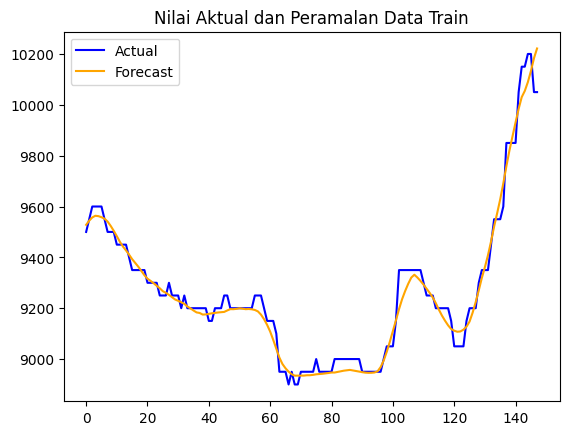

In [31]:
fig, ax = plt.subplots()

ax.plot(train_results['actuals'], color = 'blue', label = 'Actual')
ax.plot(train_results['train_predictions'], color = 'orange', label = 'Forecast')
ax.title.set_text("Nilai Aktual dan Peramalan Data Train")
ax.legend(loc = 'upper left')
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

rmse=sqrt(mean_squared_error(train_results['train_predictions'],train_results['actuals']))
mape=mean_absolute_percentage_error(train_results['train_predictions'],train_results['actuals'])
mape *= 100
print(rmse, mape)

45.57670237395899 0.3568116144976615


Model memiliki performa yang bagus pada data train dengan RMSE 45.58 dan MAPE 0.36%

In [35]:
val_predictions = model.predict(X_val).squeeze()

1/1 [==============================] - 0s 32ms/step


In [36]:
val_results = pd.DataFrame(data={'Val Predictions' : val_predictions, 'Actuals' : y_val})
val_results

,Val Predictions,Actuals
0,0.566190,0.479167
1,0.585044,0.520833
2,0.604514,0.666667
3,0.625917,0.687500
4,0.656342,0.687500
5,0.688980,0.687500
6,0.727234,0.750000
7,0.765750,0.770833
8,0.793059,0.770833


In [37]:
val_results = scaler.inverse_transform(val_results)
val_results = pd.DataFrame(list(val_results), columns=["val_predictions", "actuals"])
val_results

,val_predictions,actuals
0,10258.855152,10050.0
1,10304.105091,10150.0
2,10350.832605,10500.0
3,10402.201271,10550.0
4,10475.221300,10550.0
5,10553.552103,10550.0
6,10645.362186,10700.0
7,10737.799549,10750.0
8,10803.340721,10750.0


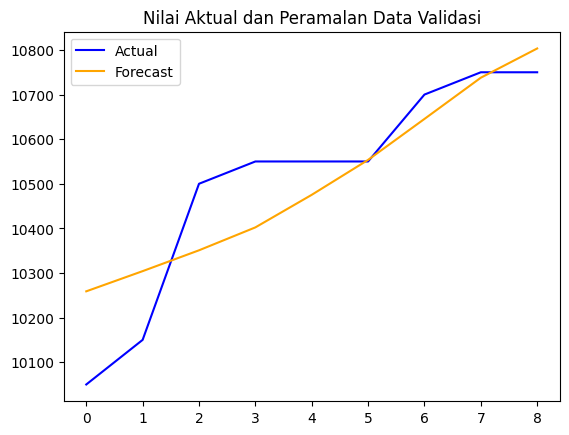

In [38]:
fig, ax = plt.subplots()

ax.plot(val_results['actuals'], color = 'blue', label = 'Actual')
ax.plot(val_results['val_predictions'], color = 'orange', label = 'Forecast')
ax.title.set_text("Nilai Aktual dan Peramalan Data Validasi")
ax.legend(loc = 'upper left')
plt.show()

In [39]:
rmse=sqrt(mean_squared_error(val_results['val_predictions'],val_results['actuals']))
mape=mean_absolute_percentage_error(val_results['val_predictions'],val_results['actuals'])
mape *= 100
print(rmse, mape)

116.92736357254401 0.9179464131655294


Dari hasil model pada data validasi tidak terdapat indikasi overfitting ataupun underfitting dilihat dari nilai MAPE yang memiliki selisih < 1% dengan MAPE data train.

In [40]:
test_predictions = model.predict(X_test).squeeze()

1/1 [==============================] - 0s 28ms/step


In [41]:
test_results = pd.DataFrame(data={'Test Predictions' : test_predictions, 'Actuals' : y_test})
test_results

,Test Predictions,Actuals
0,0.821742,0.770833
1,0.853186,0.833333
2,0.886697,0.833333
3,0.914902,0.979167
4,0.941132,0.979167
5,0.966064,0.979167
6,0.989625,1.000000
7,1.004728,1.000000


In [42]:
test_results = scaler.inverse_transform(test_results)
test_results = pd.DataFrame(list(test_results), columns=["test_predictions", "actuals"])
test_results

,test_predictions,actuals
0,10872.181654,10750.0
1,10947.647142,10900.0
2,11028.073645,10900.0
3,11095.765591,11250.0
4,11158.715820,11250.0
5,11218.554544,11250.0
6,11275.099516,11300.0
7,11311.346245,11300.0


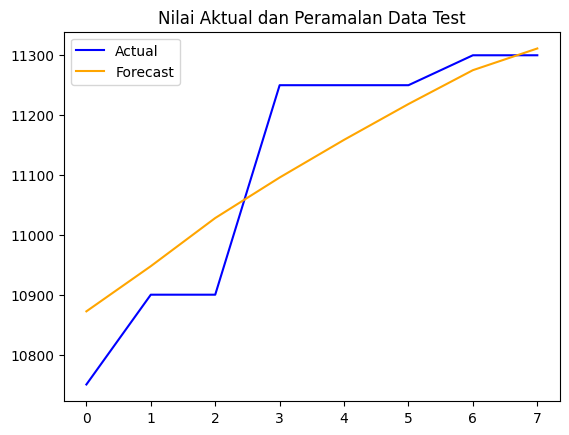

In [43]:
fig, ax = plt.subplots()

ax.plot(test_results['actuals'], color = 'blue', label = 'Actual')
ax.plot(test_results['test_predictions'], color = 'orange', label = 'Forecast')
ax.title.set_text("Nilai Aktual dan Peramalan Data Test")
ax.legend(loc = 'upper left')
plt.show()

In [44]:
rmse=sqrt(mean_squared_error(test_results['test_predictions'],test_results['actuals']))
mape=mean_absolute_percentage_error(test_results['test_predictions'],test_results['actuals'])
mape *= 100
print(rmse, mape)

91.82871809534916 0.6912380185182888


Ketika digunakan untuk meramalkan data yang belum diketahui menggunakan data testing, model memiliki performa yang baik dengan RMSE 91.83 dan MAPE 0.69%. Artinya, ketika digunakan untuk meramalkan data testing model memiliki selisih rata-rata harga peramalan dengan harga sebenarnya sebesar Rp91 dan besar kesalahan peramalan sebesar 0.69% artinya model sudah akurat untuk meramalkan data yang belum diketahui.

## Forecasting

Setelah mendapatkan model terbaik, model dapat kita gunakan untuk meramalkan data di masa depan. Sesuai dengan masa tanam padi, model digunakan untuk meramalkan harga padi pada 3 bulan setelah penanaman untuk mendapatkan estimasi pendapatan petani pada masa panen.

In [45]:
harga_beras = harga_beras.reshape((-1))

def predict(time_ahead, model):
  prediction_list = harga_beras[-12:]
  for _ in range(time_ahead):
    x = prediction_list[-12:]
    x = x.reshape((1, 12, 1))
    result = model.predict(x)[0][0]
    prediction_list = np.append(prediction_list, result)
  prediction_list = prediction_list[11:]
  return prediction_list

def predict_dates(time_ahead):
  last_date = data['tanggal'].values[-1]
  prediction_dates = pd.date_range(last_date, periods=time_ahead+1, freq='W-SAT').tolist()
  return prediction_dates

In [46]:
time_ahead = 12
forecast = predict(time_ahead, model)
forecast_dates = predict_dates(time_ahead)

1/1 [==============================] - 0s 25ms/step


In [47]:
len(forecast)

13

In [48]:
forecast_temp = pd.DataFrame(data={'forecast' : forecast, 'forecast_dup' : forecast})
forecast_temp = scaler.inverse_transform(forecast_temp)
forecast_temp = pd.DataFrame(list(forecast_temp), columns=["forecast","forecast_dup"])
forecast_temp

,forecast,forecast_dup
0,11150.000000,11150.000000
1,11344.367313,11344.367313
2,11340.512085,11340.512085
3,11339.702129,11339.702129
4,11341.388702,11341.388702
5,11339.929008,11339.929008
6,11340.956688,11340.956688
7,11344.397926,11344.397926
8,11349.683666,11349.683666
9,11362.096500,11362.096500


In [49]:
forecast_results = pd.DataFrame(data={'date' : forecast_dates, 'forecast' : forecast_temp['forecast']})
forecast_results.set_index('date', inplace=True)
forecast_results

,forecast
date,
2023-05-20,11150.000000
2023-05-27,11344.367313
2023-06-03,11340.512085
2023-06-10,11339.702129
2023-06-17,11341.388702
2023-06-24,11339.929008
2023-07-01,11340.956688
2023-07-08,11344.397926
2023-07-15,11349.683666


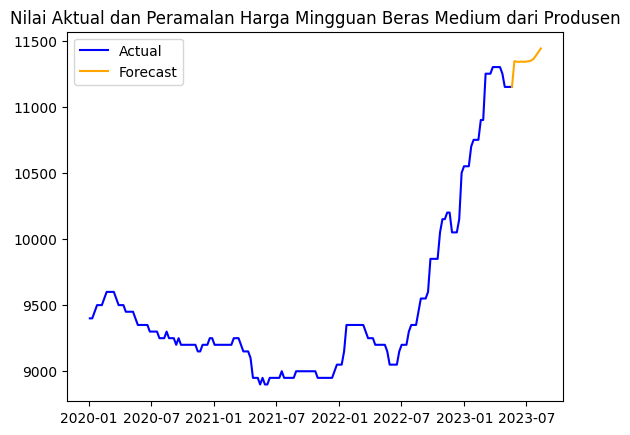

In [50]:
fig, ax = plt.subplots()

ax.plot(beras['harga'], color = 'blue', label = 'Actual')
ax.plot(forecast_results['forecast'], color = 'orange', label = 'Forecast')
ax.title.set_text("Nilai Aktual dan Peramalan Harga Mingguan Beras Medium dari Produsen")
ax.legend(loc = 'upper left')
plt.show()

Peramalan harga padi pada 3 bulan setelah tanggal yang ditentukan dapat dilihat pada tabel dan pada plot dengan warna oranye.